# Stock Projection with Tweets, News Articles and Time Series

Target Companies: Facebook, Apple, Netflix

News Sources: ABC News, Business Insider, Reuters, NBC News, The New York Times, Techcrunch, Wired

In [5]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
*The raw code for this Jupyter notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [6]:
from IPython.display import HTML
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics, cross_validation
import numpy as np
import statsmodels as sm
import matplotlib.pyplot as plt
import sklearn as skl
import sklearn.preprocessing as preprocessing
import sklearn.linear_model as linear_model
from sklearn.metrics import roc_curve, auc
import sklearn.tree as tree
import seaborn as sns
import graphviz 
from sklearn.tree import export_graphviz
from imblearn.over_sampling import SMOTE, ADASYN
from statsmodels.discrete.discrete_model import Logit
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.preprocessing import StandardScaler
from sklearn import svm
import graphviz 
from sklearn.tree import export_graphviz
from sklearn.model_selection import cross_val_score
import matplotlib.patches as mpatches
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('csv/fb_netflix_apple.csv', index_col = 0)
df['company'] = df['company'].map({'Facebook': 1, 'Netflix': 2, 'Apple': 3})
df_fb = df[df['company'] ==1]
df_nf = df[df['company'] ==2]
df_ap = df[df['company'] ==3]
target = df['up_down']
X = df.loc[:, df.columns != 'up_down']
X = X.drop(['day', 'increase_decrease','movement(%)' ], axis = 1)

# normalize the data
def normalize(column):
    minimum = X[column].min()
    maximum = X[column].max()
    diff = maximum - minimum
    norm = (X[column] - minimum) / diff
    return norm

for column in list(X.columns):
    X[column] = normalize(column)
target = target.fillna(0)
X = X.fillna(0)

# tuning the weight using SMOTE
# print(target.value_counts())
X_resampled, y_resampled = SMOTE().fit_sample(X, target) 
# print(pd.Series(y_resampled).value_counts()) #Preview synthetic sample class distribution

X_tweets = X.loc[:,'sentiment_avg_30':'count_pos, morning']
X_tweets_new = X_tweets
X_tweets_new["total_count_30"] = X_tweets_new['coun_neg, 30'] + X_tweets_new['coun_neu, 30'] + X_tweets_new['coun_pos, 30']
X_tweets_new["total_count_60"] = X_tweets_new['coun_neg, 60'] + X_tweets_new['coun_neu, 60'] + X_tweets_new['coun_pos, 60']
X_tweets_new["total_count_120"] = X_tweets_new['coun_neg, 120'] + X_tweets_new['coun_neu, 120'] + X_tweets_new['coun_pos, 120']
X_tweets_new["total_count_night_before"] = X_tweets_new['count_neg, night_before'] + X_tweets_new['count_neu, night_before'] + X_tweets_new['count_pos, night_before']
X_tweets_new["total_count_morning"] = X_tweets_new['count_neg, morning'] + X_tweets_new['count_neu, morning'] + X_tweets_new['count_pos, morning']

X_tweets_new = X_tweets_new.drop(['coun_neg, 30', 'coun_neu, 30', 'coun_pos, 30', 'coun_neg, 60', 'coun_neu, 60', 
                                  'coun_pos, 60', 'coun_neg, 120', 'coun_neu, 120', 'coun_pos, 120', 'count_neg, night_before', 
                                  'count_neu, night_before', 'count_pos, night_before','count_neg, morning','count_neu, morning', 'count_pos, morning'], axis =1)

stock_param = ['1. open','2. high','3. low','4. close','5. volume','MACD_Hist','MACD','MACD_Signal',
 'SlowK','SlowD','RSI','ADX','CCI','Aroon Up','Aroon Down','Real Middle Band','Real Upper Band',
 'Real Lower Band','Chaikin A/D','OBV']

tweets_param = ['sentiment_avg_30','coun_neg, 30','coun_neu, 30','coun_pos, 30','sentiment_avg_60',
 'coun_neg, 60','coun_neu, 60','coun_pos, 60','sentiment_avg_120','coun_neg, 120','coun_neu, 120',
 'coun_pos, 120','sentiment_night_before_avg','count_neg, night_before','count_neu', 'night_before',
 'count_pos, night_before','sentiment_morning_avg','count_neg, morning','count_neu, morning','count_pos, morning']

news_param = ['day compound avg','day positive avg','day negative avg','day neutral avg','two day neutral avg',
 'two day positive avg','two day negative avg','two day compound avg','two day wired compound avg',
 'two day nbc-news compound avg','two day abc-news compound avg','two day reuters compound avg','two day business-insider compound avg',
 'two day the-new-york-times compound avg','two day techcrunch compound avg','two day wired neg avg',
 'two day nbc-news neg avg','two day abc-news neg avg','two day reuters neg avg','two day business-insider neg avg',
 'two day the-new-york-times neg avg','two day techcrunch neg avg','two day wired pos avg','two day nbc-news pos avg',
 'two day abc-news pos avg','two day reuters pos avg','two day business-insider pos avg','two day the-new-york-times pos avg',
 'two day techcrunch pos avg','two day wired neu avg','two day nbc-news neu avg','two day abc-news neu avg',
 'two day reuters neu avg','two day business-insider neu avg','two day the-new-york-times neu avg',
 'two day techcrunch neu avg','one day wired compound avg','one day nbc-news compound avg','one day abc-news compound avg',
 'one day reuters compound avg','one day business-insider compound avg','one day the-new-york-times compound avg',
 'one day techcrunch compound avg','one day wired neg avg','one day nbc-news neg avg','one day abc-news neg avg',
 'one day reuters neg avg','one day business-insider neg avg','one day the-new-york-times neg avg',
 'one day techcrunch neg avg','one day wired pos avg','one day nbc-news pos avg','one day abc-news pos avg',
 'one day reuters pos avg','one day business-insider pos avg','one day the-new-york-times pos avg',
 'one day techcrunch pos avg','one day wired neu avg','one day nbc-news neu avg','one day abc-news neu avg',
 'one day reuters neu avg','one day business-insider neu avg','one day the-new-york-times neu avg','one day techcrunch neu avg']

### Model Comparison

#### ・Accuracy Scores for Each Model

|                       |Logistic Regression | Random Forest     | Gradient Boosting |  AdaBoost | Support Vector Machine|
|-----------------------|:-------------------|:------------------|:--------------:|:------------|-------|
|Accuracy Score (Train)|76.61% |93.55%|99.19%|100.00%|94.99%|
|Accuracy Score (Test)|61.90% |57.14%|64.29%|71.43%|60.9%|
|Accuracy Score (k-fold)|63.97% (+/- 10.43%) |66.32% (+/- 16.76%)|71.07% (+/- 9.83%)|71.73% (+/- 11.83%)|54.54% (+/- 18.53%)|

In [7]:
def test_set(X, Y) :
    data_train, data_test, target_train, target_test = train_test_split(X, Y)
    logreg = LogisticRegression()
    logreg.fit(data_train, target_train)
    predict_train = logreg.predict(data_train)
    predict_test = logreg.predict(data_test)
    cnf_matrix_train = confusion_matrix(predict_train, target_train)
    cnf_matrix_test = confusion_matrix(predict_test, target_test)
    print('train set accuracy: ' + str(metrics.accuracy_score(predict_train, target_train)))
    plot_confusion_matrix(cnf_matrix_train, classes = set(y_resampled))
    print('test set accuracy: ' + str(metrics.accuracy_score(predict_test, target_test)))
    plot_confusion_matrix(cnf_matrix_test, classes = set(y_resampled))
    print(metrics.classification_report(predict_test, target_test))
    
# test_set(X_resampled, y_resampled)

## cross validation
def k_fold(X, Y, cv = 3):
    predicted = cross_validation.cross_val_predict(LogisticRegression(), X, Y, cv=cv)
    print(metrics.accuracy_score(predicted.reshape((predicted.shape[0],1)), np.array(Y).reshape((Y.shape[0],1))))
    print(metrics.classification_report(predicted.reshape((predicted.shape[0],1)), np.array(Y).reshape((Y.shape[0],1))))

# k_fold(X_resampled, y_resampled, cv = 10)

#### ・ROC Curves for Each Model

AUC for L1: 0.68
AUC for L2: 0.66
AUC for Adaboost: 0.70
AUC for Gradient Boosting: 0.59
AUC for Random Forest: 0.69
AUC for SVM: 0.64


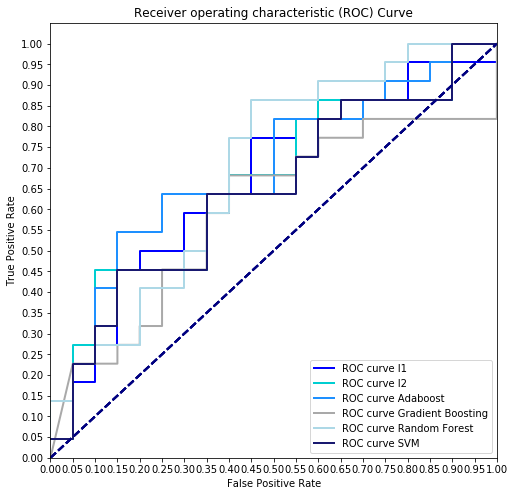

In [8]:
models = ['logistic', 'ada', 'grad', 'random', 'svm']
plt.figure(figsize=(8,8))
data_train, data_test, target_train, target_test = train_test_split(X_resampled, y_resampled)
lw = 2
for model in models:
    if model == 'logistic':
        penalties = ['l1', 'l2']
        colors = ['b', 'darkturquoise']
        area = []
        for n, pen in enumerate(penalties):
            #Fit a model
            logreg = LogisticRegression(fit_intercept = False, C = 1e12, penalty=pen) #Starter code
            model_log = logreg.fit(data_train, target_train)
            #Predict
            y_hat_test = logreg.predict(data_test)
            y_score = logreg.fit(data_train, target_train).decision_function(data_test)
            fpr, tpr, thresholds = roc_curve(target_test, y_score)
            print('AUC for {}: {:0.2f}'.format(str(pen.upper()), auc(fpr, tpr)))
            plt.plot(fpr, tpr, color=colors[n],
                     lw=lw, label='ROC curve {}'.format(pen))
            area.append(auc(fpr, tpr))
    if model == 'ada':
        area = []
        adaboost = AdaBoostClassifier(n_estimators=100)
        adaboost.fit(data_train, target_train)
        y_hat_test = adaboost.predict(data_test)
        y_score = adaboost.fit(data_train, target_train).decision_function(data_test)
        fpr, tpr, thresholds = roc_curve(target_test, y_score)

        print('AUC for {}: {:0.2f}'.format('Adaboost', auc(fpr, tpr)))
        plt.plot(fpr, tpr, color='dodgerblue',
                 lw=lw, label='ROC curve {}'.format('Adaboost'))
        area.append(auc(fpr, tpr))

    if model == 'random':
        forest= RandomForestClassifier(n_estimators= 40, max_depth= 5)
        forest.fit(data_train, target_train)
        area = []
        y_hat_test = forest.predict(data_test)
        y_score = forest.fit(data_train, target_train).predict_proba(data_test)
        fpr, tpr, thresholds = roc_curve(target_test, y_score[:,1])

        print('AUC for {}: {:0.2f}'.format('Random Forest', auc(fpr, tpr)))
        plt.plot(fpr, tpr, color='lightblue',
                 lw=lw, label='ROC curve {}'.format('Random Forest'))
        area.append(auc(fpr, tpr))

    if model == 'grad':
        area = []
        gradboost = GradientBoostingClassifier(random_state = 123, max_depth = 5, learning_rate = 0.01, n_estimators = 100)
        gradboost.fit(data_train, target_train)
        y_hat_test = gradboost.predict(data_test)
        y_score = gradboost.fit(data_train, target_train).decision_function(data_test)
        fpr, tpr, thresholds = roc_curve(target_test, y_score)
        print('AUC for {}: {:0.2f}'.format('Gradient Boosting', auc(fpr, tpr)))
        plt.plot(fpr, tpr, color='darkgrey',
                 lw=lw, label='ROC curve {}'.format('Gradient Boosting'))
        area.append(auc(fpr, tpr))

    if model == 'svm':
        area = []
        clf = svm.SVC(kernel='linear', C=1000000)
        clf.fit(data_train, target_train) 
        y_hat_test = clf.predict(data_test)
        y_score = clf.fit(data_train, target_train).decision_function(data_test)
        fpr, tpr, thresholds = roc_curve(target_test, y_score)
        print('AUC for {}: {:0.2f}'.format('SVM', auc(fpr, tpr)))
        plt.plot(fpr, tpr, color='midnightblue',
                 lw=lw, label='ROC curve {}'.format('SVM'))
        area.append(auc(fpr, tpr))

    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])

    plt.yticks([i/20.0 for i in range(21)])
    plt.xticks([i/20.0 for i in range(21)])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC) Curve')
    plt.legend(loc="lower right")
plt.show()

#### ・Correlation Heatmaps

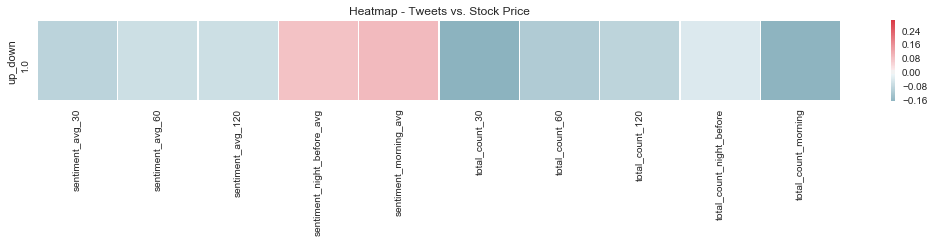

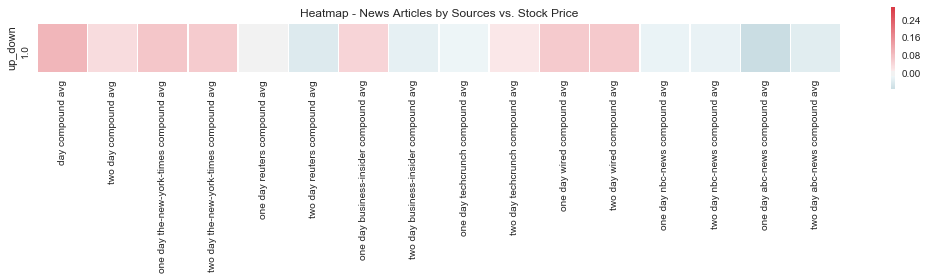

In [12]:
def correlation_heatmap(df, title = 'heatmap'):
    sns.set(style="white")
    # Compute the correlation matrix
    corr = []
    for column in list(df.columns):
        correlation = df['up_down'].corr(df[column])
        corr.append(correlation)
    corrs = pd.Series(corr).to_frame().transpose()
    corrs.columns = df.columns
    corrs = corrs.set_index('up_down')
    f, ax = plt.subplots(figsize=(18, 3))
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    # Draw the heatmap with the mask and correct aspect ratio
    ax = plt.axes()
    sns.heatmap(corrs,cmap=cmap,vmax=.3, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax = ax)
    ax.set_title(title)
    plt.show()
    
# Twitter heatmap
twitter_heatmap = pd.concat([X_tweets_new, df['up_down']], axis =1)
correlation_heatmap(twitter_heatmap, title = 'Heatmap - Tweets vs. Stock Price')

# all news heatmap
X_news = X.loc[:, 'day compound avg':]
X_news = X_news.drop(['company'], axis = 1)
# news_heabtmap = pd.concat([X_news, df['up_down']], axis =1)
# correlation_heatmap(news_heabtmap, title = 'Heatmap - News Articles vs. Stock Price')

compound_list = [source for source in X_news.columns if 'compound' in source]
compound_news = X_news[compound_list]
compound_news = compound_news[['day compound avg',
                         'two day compound avg',
                         'one day the-new-york-times compound avg',
                         'two day the-new-york-times compound avg',
                         'one day reuters compound avg',
                         'two day reuters compound avg',
                         'one day business-insider compound avg',
                         'two day business-insider compound avg',
                         'one day techcrunch compound avg',
                         'two day techcrunch compound avg',
                         'one day wired compound avg',
                         'two day wired compound avg',
                         'one day nbc-news compound avg',
                         'two day nbc-news compound avg',
                         'one day abc-news compound avg',
                         'two day abc-news compound avg',
                         ]]
news_compound_heabtmap = pd.concat([compound_news, df['up_down']], axis =1)
correlation_heatmap(news_compound_heabtmap, title = 'Heatmap - News Articles by Sources vs. Stock Price')

### AdaBoost (Adaptive Boosting)

#### Feature Importances

Top 10 Features:
('RSI', 0.18)
('1. open', 0.08)
('CCI', 0.08)
('5. volume', 0.06)
('SlowK', 0.06)
('SlowD', 0.05)
('MACD_Hist', 0.04)
('ADX', 0.04)
('MACD', 0.03)
('MACD_Signal', 0.03)


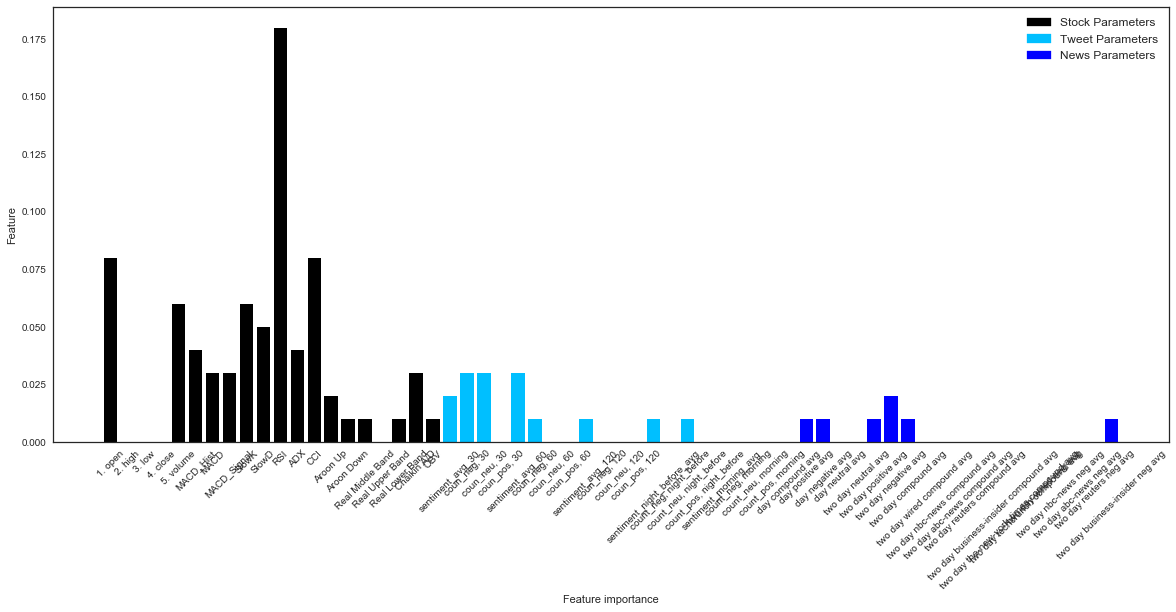

In [40]:
def plot_feature_importances(model, data):
    n_features = data.shape[1]
    plt.figure(figsize=(20,8))
    color_list = []
    for column in data.columns:
        if column in stock_param:
            color = 'black'
            color_list.append(color)
        if column in tweets_param:
            color = 'deepskyblue'
            color_list.append(color)
        if column in news_param:
            color = 'b'
            color_list.append(color)
    black_patch = mpatches.Patch(color='black', label='Stock Parameters')
    deepblue_patch = mpatches.Patch(color='deepskyblue', label='Tweet Parameters')
    blue_patch = mpatches.Patch(color='b', label='News Parameters')
    plt.bar(range(n_features)[:60], model.feature_importances_[:60], align='center', color = color_list) 
    plt.xticks(np.arange(n_features)[:60], data.columns[:60], rotation = 45) 
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.legend(handles=[black_patch,deepblue_patch,blue_patch], fontsize = 'medium')

adaboost = AdaBoostClassifier(n_estimators=100)
adaboost.fit(data_train, target_train)
# print('Train Set Score: {:0.2f}%'.format(adaboost.score(data_train, target_train) * 100))
# print('test set score: {:0.2f}%'.format(adaboost.score(data_test, target_test)*100))
plot_feature_importances(adaboost, X)


feature_importances_ada = adaboost.feature_importances_
feature_importance_list_ada = [round(value, 4) for value in feature_importances_ada]
feature_importance_ada = dict(zip(X.columns, feature_importance_list_ada))
print('Top 10 Features:')
sorted_dict_ada = sorted(feature_importance_ada.items(), key=lambda x: x[1], reverse=True)
for item in sorted_dict_ada[:10]:
    print(item)
    
# kfold_sc5ores_ada = cross_val_score(adaboost, X_resampled, y_resampled, cv=5)
# print("Accuracy: %0.2f (+/- %0.2f)" % (kfold_scores_ada.mean()*100, kfold_scores_ada.std() * 2*100))

In [26]:
# def plot_feature_importances(model, data):
#     n_features = data.shape[1]
#     plt.figure(figsize=(8,20))
#     color_list = []
#     for column in data.columns:
#         if column in stock_param:
#             color = 'black'
#             color_list.append(color)
#         if column in tweets_param:
#             color = 'deepskyblue'
#             color_list.append(color)
#         if column in news_param:
#             color = 'b'
#             color_list.append(color)
#     plt.barh(range(n_features), model.feature_importances_, align='center', color = color_list) 
#     plt.yticks(np.arange(n_features), data.columns) 
#     plt.xlabel("Feature importance")
#     plt.ylabel("Feature")

# adaboost = AdaBoostClassifier(n_estimators=100)
# adaboost.fit(data_train, target_train)
# print('Train Set Score: {:0.2f}%'.format(adaboost.score(data_train, target_train) * 100))
# print('test set score: {:0.2f}%'.format(adaboost.score(data_test, target_test)*100))
# plot_feature_importances(adaboost, X)


# feature_importances_ada = adaboost.feature_importances_
# feature_importance_list_ada = [round(value, 4) for value in feature_importances_ada]
# feature_importance_ada = dict(zip(X.columns, feature_importance_list_ada))
# print('\n', 'Top 10 Features:')
# sorted_dict_ada = sorted(feature_importance_ada.items(), key=lambda x: x[1], reverse=True)
# for item in sorted_dict_ada[:10]:
#     print(item)
    
# # kfold_sc5ores_ada = cross_val_score(adaboost, X_resampled, y_resampled, cv=5)
# # print("Accuracy: %0.2f (+/- %0.2f)" % (kfold_scores_ada.mean()*100, kfold_scores_ada.std() * 2*100))

#### After Hyper Parameter Tuning

Train Set Score: 91.13%
Test set score: 73.81%


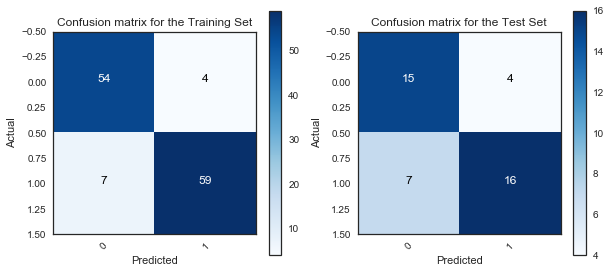

In [49]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

data_train, data_test, target_train, target_test = train_test_split(X_resampled, y_resampled)
adaboost_best = AdaBoostClassifier(n_estimators=700, learning_rate = 0.015)
adaboost_best.fit(data_train, target_train)
print('Train Set Score: {:0.2f}%'.format(adaboost_best.score(data_train, target_train) * 100))
print('Test set score: {:0.2f}%'.format(adaboost_best.score(data_test, target_test)*100))

ada_predict_train = adaboost_best.predict(data_train)
ada_predict_test = adaboost_best.predict(data_test)
ada_matrix_train = confusion_matrix(ada_predict_train, target_train)
ada_matrix_test = confusion_matrix(ada_predict_test, target_test)

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm,  cmap)
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

    class_names = set(classes) #Get class labels to add to matrix
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    thresh = cm.max() / 2. #Used for text coloring below
    #Here we iterate through the confusion matrix and append labels to our visualization.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, cm[i, j],
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    #Add a Side Bar Legend Showing Colors
    plt.colorbar()
    plt.show()

fig, ax = plt.subplots(1, 2, figsize=(10, 10))
z1_plot = ax[0].imshow(ada_matrix_train,  plt.cm.Blues)
ax[0].set_title('Confusion matrix for the Training Set')
ax[0].set_ylabel('Actual')
ax[0].set_xlabel('Predicted')

class_names = set(y_resampled) #Get class labels to add to matrix
tick_marks = np.arange(len(class_names))
ax[0].set_xticks(tick_marks)
ax[0].set_yticks(tick_marks, class_names)
ax[0].set_xticklabels(class_names, rotation=45)

thresh = ada_matrix_train.max() / 2. #Used for text coloring below
#Here we iterate through the confusion matrix and append labels to our visualization.
for i, j in itertools.product(range(ada_matrix_train.shape[0]), range(ada_matrix_train.shape[1])):
        ax[0].text(j, i, ada_matrix_train[i, j],
                 horizontalalignment="center",
                 color="white" if ada_matrix_train[i, j] > thresh else "black")
#Add a Side Bar Legend Showing Colors
fig.colorbar(z1_plot, ax = ax[0], shrink=0.45)

z2_plot = ax[1].imshow(ada_matrix_test,  plt.cm.Blues)
ax[1].set_title('Confusion matrix for the Test Set')
ax[1].set_ylabel('Actual')
ax[1].set_xlabel('Predicted')

class_names = set(y_resampled) #Get class labels to add to matrix
tick_marks = np.arange(len(class_names))
ax[1].set_xticks(tick_marks)
ax[1].set_yticks(tick_marks, class_names)
ax[1].set_xticklabels(class_names, rotation=45)

thresh = ada_matrix_test.max() / 2. #Used for text coloring below
#Here we iterate through the confusion matrix and append labels to our visualization.
for i, j in itertools.product(range(ada_matrix_test.shape[0]), range(ada_matrix_test.shape[1])):
        ax[1].text(j, i, ada_matrix_test[i, j],
                 horizontalalignment="center",
                 color="white" if ada_matrix_test[i, j] > thresh else "black")
#Add a Side Bar Legend Showing Colors
fig.colorbar(z2_plot, ax = ax[1], shrink=0.45)

plt.show()
# plot_confusion_matrix(ada_matrix_train, classes = set(y_resampled))
# plot_confusion_matrix(ada_matrix_test, classes = set(y_resampled))

#### Tweets 

In [16]:
tweets_30 = ['sentiment_avg_30', 'coun_neg, 30', 'coun_neu, 30', 'coun_pos, 30','total_count_30']
tweets_60 = ['sentiment_avg_60', 'coun_neg, 60', 'coun_neu, 60', 'coun_pos, 60','total_count_60']
tweets_120 = ['sentiment_avg_120', 'coun_neg, 120', 'coun_neu, 120', 'coun_pos, 120','total_count_120']
tweets_night = [ 'sentiment_night_before_avg', 'count_neg, night_before','count_neu, night_before', 'count_pos, night_before','total_count_night_before']
tweets_morning = ['sentiment_morning_avg', 'count_neg, morning', 'count_neu, morning',
       'count_pos, morning', 'total_count_morning']

In [21]:
def plot_feature_importances_tweets(model, data):
    n_features = data.shape[1]
    plt.figure(figsize=(20,8))
    color_list = []
    for column in data.columns:
        if column in tweets_30:
            color = 'darkturquoise'
            color_list.append(color)
        if column in tweets_60:
            color = 'deepskyblue'
            color_list.append(color)
        if column in tweets_120:
            color = 'b'
            color_list.append(color)
        if column in tweets_night:
            color = 'royalblue'
            color_list.append(color)
        if column in tweets_morning:
            color = 'lightgrey'
            color_list.append(color)
    patch_30 = mpatches.Patch(color='darkturquoise', label='30mins')
    patch_60 = mpatches.Patch(color='deepskyblue', label='1 hr')
    patch_120 = mpatches.Patch(color='b', label='2hrs')
    patch_morning = mpatches.Patch(color='royalblue', label='Morning - the day of')
    patch_night = mpatches.Patch(color='lightgrey', label='Night Before')
    
    plt.legend(handles=[patch_30,patch_60,patch_120,patch_morning,patch_night],fontsize = 'medium')
    plt.bar(range(n_features), model.feature_importances_, align='center', color = color_list) 
    plt.xticks(np.arange(n_features), data.columns, rotation=45) 
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")

Train Set Score: 88.89%
test set score: 61.54%

 Top 10 Features:
('total_count_30', 0.15)
('sentiment_avg_30', 0.14)
('coun_neg, 30', 0.08)
('coun_neu, 60', 0.08)
('total_count_60', 0.08)
('sentiment_avg_60', 0.07)
('coun_neu, 30', 0.06)
('coun_pos, 30', 0.06)
('coun_pos, 120', 0.05)
('coun_neg, 60', 0.04)


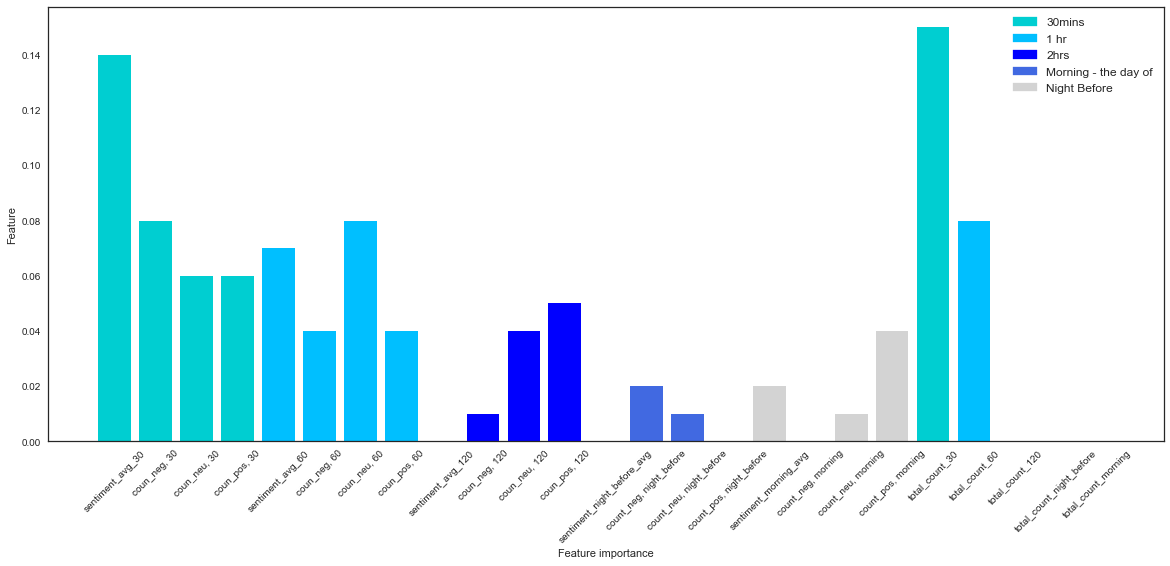

In [32]:
data_train_tweets, data_test_tweets, target_train_tweets, target_test_tweets = train_test_split(X_tweets, target)
adaboost_tweets = AdaBoostClassifier(n_estimators=100)
adaboost_tweets.fit(data_train_tweets, target_train_tweets)
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.005, n_estimators=100, random_state=None)
print('Train Set Score: {:0.2f}%'.format(adaboost_tweets.score(data_train_tweets, target_train_tweets) * 100))
print('test set score: {:0.2f}%'.format(adaboost_tweets.score(data_test_tweets, target_test_tweets)*100))
plot_feature_importances_tweets(adaboost_tweets, X_tweets)

feature_importances_ada_tweets = adaboost_tweets.feature_importances_
feature_importance_list_ada_tweets = [round(value, 4) for value in feature_importances_ada_tweets]
feature_importance_ada_tweets = dict(zip(X_tweets.columns, feature_importance_list_ada_tweets))
print('\n', 'Top 10 Features:')
sorted_dict_ada_tweets = sorted(feature_importance_ada_tweets.items(), key=lambda x: x[1], reverse=True)
for item in sorted_dict_ada_tweets[:10]:
    print(item)

#### News Source

News Sources: ABC News, Business Insider, Reuters, NBC News, The New York Times, Techcrunch, Wired

In [10]:
news_df = X.loc[:,'two day wired compound avg':]
news_df = news_df.drop(['company'], axis = 1)

ABC_News = ['two day abc-news compound avg','two day abc-news pos avg','two day abc-news neu avg','one day abc-news compound avg','one day abc-news neg avg','one day abc-news pos avg']
Business_Insider = ['two day business-insider compound avg', 'two day business-insider neg avg','two day business-insider pos avg','two day business-insider neu avg','one day business-insider compound avg','one day business-insider neg avg','one day business-insider pos avg','one day business-insider neu avg']
Reuters = ['two day reuters compound avg', 'two day reuters neg avg','two day reuters pos avg','two day reuters neu avg', 'one day reuters compound avg','one day reuters neg avg','one day reuters pos avg','one day reuters neu avg']
NBC_News = ['two day nbc-news compound avg', 'two day nbc-news neg avg', 'two day nbc-news pos avg','two day nbc-news neu avg','one day nbc-news compound avg', 'one day nbc-news neg avg','one day nbc-news pos avg','one day nbc-news neu avg','one day abc-news neu avg']
The_New_York_Times = ['two day the-new-york-times compound avg', 'two day the-new-york-times neg avg','two day the-new-york-times pos avg','two day the-new-york-times neu avg','one day the-new-york-times compound avg','one day the-new-york-times neg avg','one day the-new-york-times pos avg','one day the-new-york-times neu avg']
Techcrunch = ['two day techcrunch compound avg', 'two day techcrunch neg avg','two day techcrunch pos avg','two day techcrunch neu avg','one day techcrunch compound avg','one day techcrunch neg avg','one day techcrunch pos avg','one day techcrunch neu avg',]
Wired = ['two day wired compound avg', 'two day wired neg avg', 'two day wired pos avg','two day wired neu avg','one day wired compound avg','one day wired neg avg', 'one day wired pos avg','one day wired neu avg']

def plot_feature_importances_news(model, data):
    n_features = data.shape[1]
    plt.figure(figsize=(8,20))
    color_list = []
    for column in data.columns:
        if column in ABC_News:
            color = 'black'
            color_list.append(color)
        if column in Business_Insider:
            color = 'deepskyblue'
            color_list.append(color)
        if column in Reuters:
            color = 'orange'
            color_list.append(color)
        if column in NBC_News:
            color = 'yellow'
            color_list.append(color)
        if column in The_New_York_Times:
            color = 'grey'
            color_list.append(color)
        if column in Techcrunch:
            color = 'green'
            color_list.append(color)
        if column in Wired:
            color = 'darkorchid'
            color_list.append(color)
    patch_abc = mpatches.Patch(color='black', label='ABC News')
    patch_bi = mpatches.Patch(color='deepskyblue', label='Business Insider')
    patch_reuters = mpatches.Patch(color='orange', label='Reuters')
    patch_nbc = mpatches.Patch(color='yellow', label='NBC News')
    patch_nyt = mpatches.Patch(color='grey', label='The New York Times')
    patch_techcrunch = mpatches.Patch(color='green', label='Techcrunch')
    patch_wired = mpatches.Patch(color='darkorchid', label='Wired')
    
    plt.legend(handles=[patch_abc,patch_bi,patch_reuters, patch_nbc, patch_nyt, patch_techcrunch, patch_wired], fontsize = 'medium') 
    
    plt.barh(range(n_features), model.feature_importances_, align='center', color = color_list) 
    plt.yticks(np.arange(n_features), data.columns) 
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")


Train Set Score: 75.21%
test set score: 53.85%

 Top 10 Features:
('one day abc-news neg avg', 0.1)
('two day abc-news neg avg', 0.07)
('two day reuters pos avg', 0.07)
('one day reuters neg avg', 0.07)
('two day business-insider neg avg', 0.06)
('one day business-insider neg avg', 0.06)
('one day business-insider compound avg', 0.05)
('one day reuters pos avg', 0.05)
('one day reuters compound avg', 0.04)
('one day the-new-york-times neg avg', 0.04)


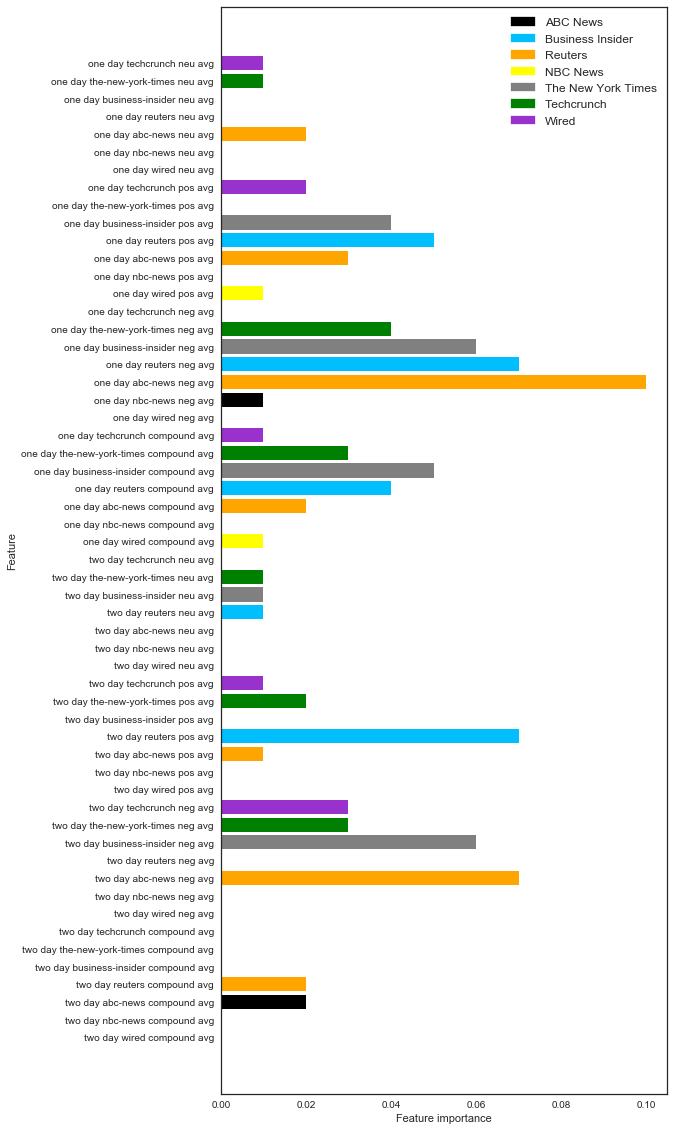

In [36]:
data_train_news, data_test_news, target_train_news, target_test_news = train_test_split(news_df, target)
adaboost_news = AdaBoostClassifier(n_estimators=100)
adaboost_news.fit(data_train_news, target_train_news)
print('Train Set Score: {:0.2f}%'.format(adaboost_news.score(data_train_news, target_train_news) * 100))
print('test set score: {:0.2f}%'.format(adaboost_news.score(data_test_news, target_test_news)*100))
plot_feature_importances_news(adaboost_news, news_df)

feature_importances_ada_news = adaboost_news.feature_importances_
feature_importance_list_ada_news = [round(value, 4) for value in feature_importances_ada_news]
feature_importance_ada_news = dict(zip(news_df.columns, feature_importance_list_ada_news))
print('\n', 'Top 10 Features:')
sorted_dict_ada_news = sorted(feature_importance_ada_news.items(), key=lambda x: x[1], reverse=True)
for item in sorted_dict_ada_news[:10]:
    print(item)